In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# change this to the path in google drive where the files are located
%cd /content/drive/MyDrive/TDDE16-Project

Mounted at /content/drive
/content/drive/MyDrive/TDDE16-Project


In [ ]:
#!pip install transformers
import re
import torch
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler

In [ ]:
pd.set_option('display.max_colwidth', 200)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
DATA_PATH = 'IMDB Dataset.csv'
SAVED_MODEL_PATH = '/content/drive/MyDrive/TDDE16-Project/'
BERT_MODEL = 'bert-base-uncased'

# Configuration for the BERT model
MAX_LEN = 512
BATCH_SIZE = 16
NUM_CLASSES = 2
LEARNING_RATE = 2e-5
NUM_EPOCHS= 5

In [ ]:
# Cleaning the data
data = (pd.read_csv(DATA_PATH).drop_duplicates())
print(f'Numbers of samples: {len(data)}')
data.head()

Numbers of samples: 49582


,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",positive


In [ ]:
# Converting the target valur to integers
data['sentiment'] = data['sentiment'].apply(lambda x: 0 if x == "negative" else 1)
print(data['sentiment'].value_counts())

1    24884
0    24698
Name: sentiment, dtype: int64


In [ ]:
# Creating train, validation and test datasets
train_df, test_val_df = train_test_split(data, test_size=0.3, stratify=data['sentiment'], random_state=20)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, stratify=test_val_df['sentiment'], random_state=20)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(f'Length of train set: {len(train_df)}')
print(f'Length of validation set: {len(val_df)}')
print(f'Length of test set: {len(test_df)}')

Length of train set: 34707
Length of validation set: 7437
Length of test set: 7438


In [ ]:
# Class for creating dataset
# To be passed as an argument to the Dataloader
class CreateDataset(Dataset):
    def __init__(self, review, target, tokenizer, max_len, clean_text=None):
        self.clean_text = clean_text
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.review)

    def __getitem__(self, idx):
        y = torch.tensor(self.target[idx], dtype=torch.long)
        X = str(self.review[idx])
        if self.clean_text:
            X = self.clean_text(X)
        
        encoded_X = self.tokenizer(
            X, 
            return_tensors = 'pt', 
            max_length = self.max_len, 
            truncation=True,
            padding = 'max_length'
            )

        return {'input_ids': encoded_X['input_ids'].squeeze(),
                'attention_mask': encoded_X['attention_mask'].squeeze(),
                'labels': y}

In [ ]:
# Traing function
def train(model, dataloader, optimizer, scheduler, device, progress_bar):

    losses = []
    accuracies = []

    model.train()
    for batch in dataloader:

        optimizer.zero_grad()
        batch = {k:v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()

        preds = torch.argmax(outputs.logits, dim=1)
        acc = torch.sum(preds == batch['labels']) / len(preds)
        accuracies.append(acc)
        losses.append(loss)

        progress_bar.update(1)
    
    return torch.tensor(losses, dtype=torch.float).mean().item(), torch.tensor(accuracies).mean().item()

In [ ]:
# Evaluation function
def evaluate(model, dataloader, device):
    losses = []
    accuracies = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:

            batch = {k:v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss

            preds = torch.argmax(outputs.logits, dim=1)
            acc = torch.sum(preds == batch['labels']) / len(preds)
            accuracies.append(acc)
            losses.append(loss)
        
        return torch.tensor(losses, dtype=torch.float).mean().item(), torch.tensor(accuracies).mean().item()

In [ ]:
# Test function
def test(model, dataloader, device):
    y_preds = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:

            batch = {k:v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
         
            y_preds.extend( torch.argmax(outputs.logits, dim=1) )
            y_true.extend( batch['labels'])
            
        return y_preds, y_true

In [ ]:
# Function to Removes html tags and  extra whitespaces.
def clean_text(text):
    text =  " ".join(text.split())
    text = re.sub(r'<.*?>', '', text)
    return text

In [ ]:
# Tokenizing the data using BertTokenizer
# Using Dataloader
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
dfs = {'train':train_df, 'val':val_df, 'test':test_df}
dataloaders = {}

for df in dfs:
    should_shuffle = True if df == 'train' else False
    dataloaders[df] = DataLoader(CreateDataset(dfs[df]['review'],  dfs[df]['sentiment'], tokenizer=tokenizer, max_len=MAX_LEN, clean_text=clean_text),
                                  batch_size=BATCH_SIZE, shuffle=should_shuffle)

In [ ]:
# Testing the dataloader
for batch in dataloaders['train']:
    print({k:v.shape for k, v in batch.items()})
    break

{'input_ids': torch.Size([16, 512]), 'attention_mask': torch.Size([16, 512]), 'labels': torch.Size([16])}


In [ ]:
# Setting up the model, the optimizer and the scheduler
# Using BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=NUM_CLASSES)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

num_training_steps = NUM_EPOCHS * len(dataloaders['train'])
scheduler = get_scheduler(
    'linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Test 
outputs = model(**{k:v.to(device) for k, v in batch.items()})
print(outputs.loss, outputs.logits.shape)

tensor(0.7453, device='cuda:0', grad_fn=<NllLossBackward0>) torch.Size([16, 2])


In [ ]:
# Training and evaluation
progress_bar = tqdm(range(num_training_steps))
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc': []}

best_accuracy = 0
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model, dataloaders['train'], optimizer, scheduler, device, progress_bar)
    print(f'Train Loss: {train_loss :.4f} | Accuracy: {train_acc*100 :.2f}')

    val_loss, val_acc = evaluate(model, dataloaders['val'], device)
    print(f'Eval Loss: {val_loss :.4f} | Accuracy: {val_acc*100 :.2f}')

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # save best model
    if val_acc > best_accuracy:
        model.save_pretrained(SAVED_MODEL_PATH)
        best_accuracy = val_acc
        
    print('-'*50)

  0%|          | 0/10850 [00:00<?, ?it/s]

Train Loss: 0.2131 | Accuracy: 91.53
Eval Loss: 0.1760 | Accuracy: 93.40
--------------------------------------------------
Train Loss: 0.1004 | Accuracy: 96.56
Eval Loss: 0.1842 | Accuracy: 93.93
--------------------------------------------------
Train Loss: 0.0433 | Accuracy: 98.65
Eval Loss: 0.2187 | Accuracy: 93.92
--------------------------------------------------
Train Loss: 0.0189 | Accuracy: 99.50
Eval Loss: 0.2856 | Accuracy: 93.86
--------------------------------------------------
Train Loss: 0.0098 | Accuracy: 99.78
Eval Loss: 0.2910 | Accuracy: 94.04
--------------------------------------------------


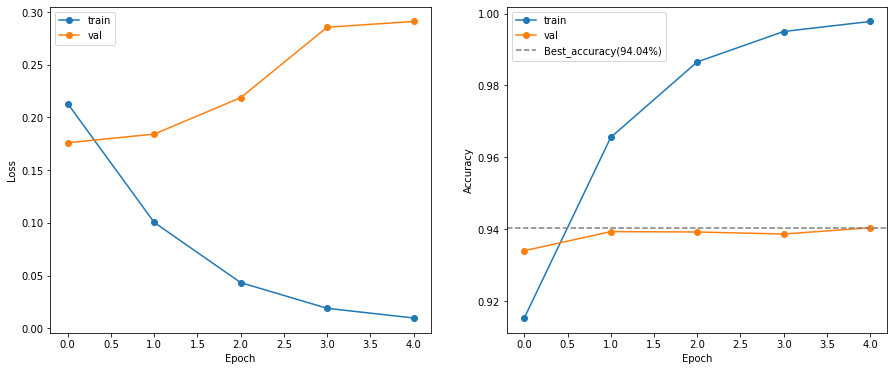

In [ ]:
# Plotting the results
x_epochs = list(range(NUM_EPOCHS))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, history['train_loss'], marker='o', label='train')
plt.plot(x_epochs, history['val_loss'], marker='o', label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_epochs, history['train_acc'], marker='o', label='train')
plt.plot(x_epochs, history['val_acc'], marker='o', label='val')
plt.axhline(best_accuracy, c='grey', ls='--',
            label=f'Best_accuracy({best_accuracy*100 :.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_preds, y_true = test(model,dataloaders['test'], device)

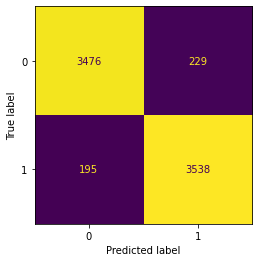

In [ ]:
_ , ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(torch.tensor(y_true), torch.tensor(y_preds), ax = ax, colorbar = False);

In [ ]:
print(classification_report(torch.tensor(y_true), torch.tensor(y_preds)))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3705
           1       0.94      0.95      0.94      3733

    accuracy                           0.94      7438
   macro avg       0.94      0.94      0.94      7438
weighted avg       0.94      0.94      0.94      7438

